In [1]:
import pandas as pd

import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

import glob

# from pylab import rcParams
# sns.set(style='whitegrid', palette='muted', font_scale=1.5)
# rcParams['figure.figsize'] = 8, 6

# import contextily as ctx

# !pip install xlrd==1.2.0
# !pip install convertbng
# from convertbng.util import convert_lonlat

pd.set_option('display.max_columns', None)

# import folium

In [14]:
London = gpd.read_file('../data/london_general/London_boundaries.geojson')
lsoa = gpd.read_file('../data/london_general/statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp')
msoa = gpd.read_file('../data/london_general/statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp')

In [23]:
# # https://geoportal.statistics.gov.uk/datasets/national-statistics-postcode-lookup-august-2021/about
# postcodes = pd.read_csv('../data/NSPL_AUG_2021_UK/Data/NSPL_AUG_2021_UK.csv',
#                         low_memory=False)
# # filter postcodes in London
# postcodes = postcodes[postcodes['laua'].str.contains('E09', na=False)]
# postcodes = postcodes[['pcd2', 'oa11', 'lsoa11', 'msoa11', 'wz11', 'lat', 'long']]
# postcodes.to_csv('../data/london_general/london_postcodes.csv', index=False)
postcodes = pd.read_csv('../data/london_general/london_postcodes.csv')
postcodes = postcodes[['pcd2', 'msoa11', 'lat', 'long']]

### 0. Check what data is missing in the 'non-publishing' authorities like Westminster or Islington?

Islington is non-publishng, Camden is publishing –> check differences

In [6]:
i = pd.read_csv('../data/retail/Whythawk/new_merged_reports/2021-03-E09000019-islington-location-report.csv')

In [7]:
i.head(2)

,rates_code,rates_authority_id,rates_authority,region,location_code,address_no,address_street,address_town,pc__pcs,use_category,scat_code,sub_category,category,floor_area,rental_valuation,valuation_date,revaluation_year,period,rates_expected,name,rates_paid,status,status_duration,status_date,ratepayers_published
0,NaN,E09000019,Islington,Inner London - East,11530103000,PT GND & PT LGND FLRS 36,CHANCERY LANE,LONDON,EC2A 1EN,Shops,249,Retail High Street,Retail,258.09,124000.0,2017-12-19 00:00:00+00:00,2017,2021-03,63488.0,NaN,NaN,1.0,NaN,2017-12-19,False
1,NaN,E09000019,Islington,Inner London - East,11811304000,LGND FLR 28,CHANCERY LANE,LONDON,EC2A 1LB,Offices (Inc Computer Centres),203,Office General,Office,547.00,220000.0,2018-01-22 00:00:00+00:00,2017,2021-03,112640.0,NaN,NaN,1.0,NaN,2018-01-22,False


In [8]:
c = pd.read_csv('../data/retail/Whythawk/new_merged_reports/2021-03-E09000007-camden-location-report.csv')

In [9]:
c.head(2)

,rates_code,rates_authority_id,rates_authority,region,location_code,address_no,address_street,address_town,pc__pcs,use_category,scat_code,sub_category,category,floor_area,rental_valuation,valuation_date,revaluation_year,period,rates_expected,name,rates_paid,status,status_date,status_duration,ratepayers_published
0,00000012905006,E09000007,Camden,Inner London - West,97305063,QUEENS HEAD & ARTICHOKE 30-32,ALBANY STREET,LONDON,NW1 4EA,Public Houses/Pub Restaurants (National Scheme),226,Retail Restaurants & Cafes,Retail,210.583902,100000.0,2017-04-01 00:00:00+00:00,2017,2021-03,51200.0,ARTICHOKE HEART LTD,8901.0,True,2010-04-01,4018.0,True
1,00000020101013,E09000007,Camden,Inner London - West,3574848000,213,EVERSHOLT STREET,LONDON,NW1 1DE,Shops,249,Retail High Street,Retail,52.000000,5300.0,2017-04-01 00:00:00+00:00,2017,2021-03,2644.7,ZAD FOUNDATION,0.0,True,2016-10-05,1639.0,True


In [10]:
i.isna().sum()

rates_code              13708
rates_authority_id          0
rates_authority             0
region                      0
location_code               0
address_no                  0
address_street             32
address_town                0
pc__pcs                     0
use_category                0
scat_code                   0
sub_category                0
category                  976
floor_area                  0
rental_valuation            0
valuation_date              0
revaluation_year            0
period                      0
rates_expected              0
name                    13708
rates_paid              13708
status                      0
status_duration         13708
status_date                 0
ratepayers_published        0
dtype: int64

In [11]:
c.isna().sum()

rates_code                 0
rates_authority_id         0
rates_authority            0
region                     0
location_code              0
address_no                 2
address_street             0
address_town               0
pc__pcs                    0
use_category               0
scat_code                  0
sub_category               0
category                1458
floor_area                 0
rental_valuation           0
valuation_date             0
revaluation_year           0
period                     0
rates_expected             0
name                    2316
rates_paid              2474
status                     0
status_date                0
status_duration         2314
ratepayers_published       0
dtype: int64

In [13]:
i.status.value_counts()

1.0    13708
Name: status, dtype: int64

In [12]:
c.status.value_counts()

True     14358
False     3028
Name: status, dtype: int64

Non-publishing authorities do not publish information about ratepayers including the following columns: rates_code, name, rates_paid, status_duration

### Map publishing authorities

In [9]:
msoa_cropped = gpd.read_file('../data/output.msoa_cropped.geojson')

In [10]:
files = glob.glob('../data/retail/Whythawk/new_merged_reports/2021-03*')

df = pd.concat(map(pd.read_csv, files))

whythawk_boroughs = df[['rates_authority_id','status']].groupby(['rates_authority_id']).nunique().reset_index()

In [15]:
whythawk_boroughs_gdf = London[['lad15cd','lad15nm','geometry']].merge(whythawk_boroughs, how='inner', left_on='lad15cd', right_on='rates_authority_id')

<AxesSubplot:>

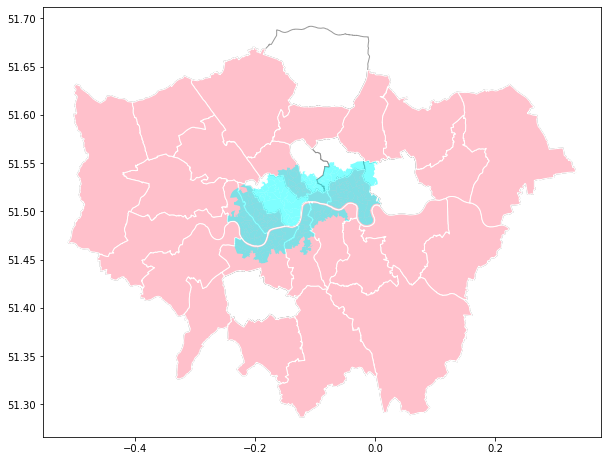

In [16]:
fig, ax = plt.subplots(figsize=(10,8))

London.plot(ax=ax, color='white', edgecolor='grey', alpha=0.8)
whythawk_boroughs_gdf[whythawk_boroughs_gdf.status==2].plot(ax=ax, color='pink', edgecolor='white');
msoa_cropped = msoa_cropped.to_crs(whythawk_boroughs_gdf.crs)
msoa_cropped.plot(ax=ax, color='cyan', alpha=0.5)

Map above shows if borough has occupancy data. Pink means it has, white (empty) means it doesn't.  
Cyan is the study area with mobility data

In [17]:
whythawk_boroughs_gdf.status.value_counts()

2    27
1     6
Name: status, dtype: int64

In [18]:
whythawk_boroughs_gdf[whythawk_boroughs_gdf.status==1]

,lad15cd,lad15nm,geometry,rates_authority_id,status
9,E09000010,Enfield,"POLYGON ((-0.09686 51.69055, -0.09723 51.69061...",E09000010,1
11,E09000012,Hackney,"POLYGON ((-0.05998 51.57542, -0.06006 51.57560...",E09000012,1
18,E09000019,Islington,"POLYGON ((-0.11921 51.57500, -0.11937 51.57526...",E09000019,1
23,E09000024,Merton,"POLYGON ((-0.19005 51.44080, -0.19004 51.44099...",E09000024,1
24,E09000025,Newham,"POLYGON ((0.05636 51.55858, 0.05633 51.55859, ...",E09000025,1
32,E09000033,Westminster,"POLYGON ((-0.17401 51.53804, -0.17407 51.53811...",E09000033,1


While occupancy data is important, it narrows down the study area way too much.  
Might leave it for discussion only

In [19]:
intersected_boroughs = gpd.sjoin(whythawk_boroughs_gdf, msoa_cropped, how="inner", op="contains")
intersected_boroughs_list = (list(intersected_boroughs['lad15cd'].unique()))
# for some reason sjoin fails to get Newham and City of London even though they clearly have some msoa_cropped within
intersected_boroughs_list.append('E09000025')
intersected_boroughs_list.append('E09000001')

In [20]:
len(intersected_boroughs_list)

12

In [21]:
intersected_boroughs_list

['E09000007',
 'E09000012',
 'E09000013',
 'E09000019',
 'E09000020',
 'E09000022',
 'E09000028',
 'E09000030',
 'E09000032',
 'E09000033',
 'E09000025',
 'E09000001']

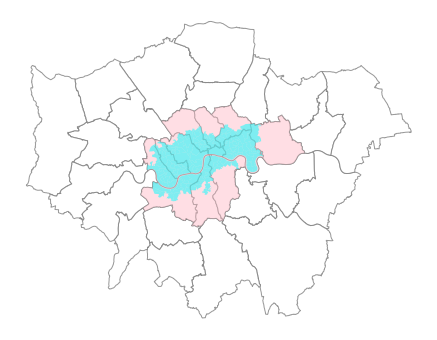

In [160]:
fig, ax = plt.subplots(figsize=(8,6))

London.plot(ax=ax, color='white', edgecolor='grey', alpha=0.8)
whythawk_boroughs_gdf[whythawk_boroughs_gdf['rates_authority_id'].isin(intersected_boroughs_list)].plot(ax=ax, color='pink', alpha=0.5);
msoa_cropped.plot(ax=ax, color='cyan', alpha=0.5)
ax.set_axis_off();

In [126]:
intersected_boroughs_list

['E09000007',
 'E09000012',
 'E09000013',
 'E09000019',
 'E09000020',
 'E09000022',
 'E09000028',
 'E09000030',
 'E09000032',
 'E09000033',
 'E09000025']

### Check categories and subcategories in the dataset

In [22]:
df = c.copy()

In [60]:
df.category.nunique()

4

In [61]:
df.category.value_counts()

Office        76178
Retail        53403
Industrial    12326
Leisure        2243
Name: category, dtype: int64

In [62]:
df.sub_category.nunique()

23

In [63]:
df.sub_category.value_counts().head(15)

Office General                                 75532
Retail High Street                             42417
Other Public                                   11141
Industrial General                             10932
Retail Restaurants & Cafes                      8499
Other Commercial                                2678
Retail Other Superstores/ Retail Warehouses     1497
Retail Financial & Professional Services         882
Warehousing  Large Scale and High Bay            756
Leisure Sports centres and Private Clubs         708
Leisure General Hotels (3 star)                  643
Industrial Light                                 578
Office IT / Data Centres                         394
Leisure Amusement & Entertainment Centres        382
Leisure Budget Hotels                            289
Name: sub_category, dtype: int64

In [51]:
df.use_category.nunique()

220

In [52]:
df.use_category.value_counts().head(15)

Offices (Inc Computer Centres)                                   70878
Shops                                                            35208
Factories, Workshops and Warehouses (Incl Bakeries & Dairies)    10841
Stores                                                            5042
Restaurants                                                       4826
Business Units                                                    3583
Communication Stations (National Scheme)                          3158
Advertising Right                                                 2442
Public Houses/Pub Restaurants (National Scheme)                   1930
Surgeries, Clinics, Health Centres (Rental Valuation)             1556
Cafes                                                             1495
Car Spaces                                                        1479
Showrooms                                                          995
Community Day Centres                                              989
Sales 

#### look deeper into categories
#### offices

In [64]:
df[df.category=='Office']['sub_category'].value_counts()

Office General              75532
Office IT / Data Centres      394
Office Serviced Office        236
Office Business Park           16
Name: sub_category, dtype: int64

In [65]:
df[df.category=='Office']['use_category'].value_counts()

Offices (Inc Computer Centres)                          70878
Business Units                                           3583
Day Nurseries/Play Schools                                627
Studios                                                   313
Computer Centres (Purpose Built)                          156
Universities (Excluding Oxbridge) (National Scheme)       155
Colleges of Further Education (National Scheme)           152
Recording Studios                                          81
Offices Within/Part of Specialist Property                 62
Training Centre (Non Residential)                          52
Offices (Headquarters/Institutional)                       39
Educational Miscellaneous                                  23
Sales Offices                                              20
Laboratories                                               16
Computer Centres (Non-Purpose Built)                       10
Nurseries/Creches Within/Part of Specialist Property        8
Boathous

#### retail

In [69]:
df[df.category=='Retail']['sub_category'].value_counts()

Retail High Street                             42417
Retail Restaurants & Cafes                      8499
Retail Other Superstores/ Retail Warehouses     1497
Retail Financial & Professional Services         882
Retail Food Superstores                          108
Name: sub_category, dtype: int64

In [237]:
df[df.sub_category=='Retail High Street']['use_category'].value_counts()

Restaurants                                                     5165
Public Houses/Pub Restaurants (National Scheme)                 2081
Cafes                                                           1542
Wine Bars                                                        191
Takeaway Food Outlet (Predominantly Off Premises)                 40
Cafes/Restaurants Within/Part of Specialist Property              37
Drive-Thru Restaurants                                            19
Drive-In Restaurants                                              10
Food Courts                                                        4
Public Houses/Pub Restaurants (Inc. Lodge) (National Scheme)       4
Roadside Restaurants (National Scheme)                             2
Coaching Inns                                                      1
Name: use_category, dtype: int64

In [70]:
df[df.category=='Retail']['use_category'].value_counts()

Shops                                                           35208
Stores                                                           5042
Restaurants                                                      4826
Public Houses/Pub Restaurants (National Scheme)                  1930
Cafes                                                            1495
Showrooms                                                         995
Sales Kiosks                                                      870
Hairdressing/Beauty Salons                                        662
Banks/Insurance/Building Society Offices & Other A2 Uses          473
Betting Offices                                                   409
Pitches for Stalls, Sales or Promotions                           142
Wine Bars                                                         132
Retail Warehouses and Foodstores                                  115
Public Telephone Kiosks (National Scheme)                         113
Food Stores         

In [71]:
df[df.sub_category=='Retail Other Superstores/ Retail Warehouses']['use_category'].value_counts()

Showrooms                                     995
Retail Warehouses and Foodstores              115
Large Shops (Over 1850m^2)                    107
Hypermarkets/Superstores (over 2500m^2)        78
Large Food Stores (750 - 2500m^2)              76
Car Showrooms                                  43
Car/Caravan Sales/Display/Hiring Sites         32
Garden Centres                                 18
Large Shops (750 - 1850m^2)                    18
Departmental and Walk Round Stores (Large)     15
Name: use_category, dtype: int64

In [72]:
df[df.sub_category=='Retail Food Superstores']['use_category'].value_counts()

Food Stores    108
Name: use_category, dtype: int64

#### industrial

In [73]:
df[df.category=='Industrial']['sub_category'].value_counts()

Industrial General                       10932
Warehousing  Large Scale and High Bay      756
Industrial Light                           578
Warehouse & Distribution                    60
Name: sub_category, dtype: int64

#### leisure

In [74]:
df[df.category=='Leisure']['sub_category'].value_counts()

Leisure Sports centres and Private Clubs     708
Leisure General Hotels (3 star)              643
Leisure Amusement & Entertainment Centres    382
Leisure Budget Hotels                        289
Leisure Periodic Use                         132
Leisure Cultural Attractions                  87
Leisure 4/ 5 Star Hotels                       2
Name: sub_category, dtype: int64

In [28]:
df.isna().sum()

rates_code                 0
rates_authority_id         0
rates_authority            0
region                     0
location_code              0
address_no                 2
address_street             0
address_town               0
pc__pcs                    0
use_category               0
scat_code                  0
sub_category               0
category                1458
floor_area                 0
rental_valuation           0
valuation_date             0
revaluation_year           0
period                     0
rates_expected             0
name                    2316
rates_paid              2474
status                     0
status_date                0
status_duration         2314
ratepayers_published       0
dtype: int64

In [30]:
df[df.address_street.str.contains('BRECKNOCK')].head()

,rates_code,rates_authority_id,rates_authority,region,location_code,address_no,address_street,address_town,pc__pcs,use_category,scat_code,sub_category,category,floor_area,rental_valuation,valuation_date,revaluation_year,period,rates_expected,name,rates_paid,status,status_date,status_duration,ratepayers_published
1224,00233000110015,E09000007,Camden,Inner London - West,11947063,1,BRECKNOCK ROAD,LONDON,N7 0BL,Restaurants,234,Retail Restaurants & Cafes,Retail,72.16,15750.0,2017-04-01 00:00:00+00:00,2017,2021-03,7859.25,NEWQUEST PROPERTIES LTD,0.00,False,2012-02-10,3338.0,True
1225,0023300030000B,E09000007,Camden,Inner London - West,11957063,3,BRECKNOCK ROAD,LONDON,N7 0BL,Shops,249,Retail High Street,Retail,94.38,17500.0,2017-04-01 00:00:00+00:00,2017,2021-03,8732.50,EL-GAMAL & CO LIMITED,0.00,False,2014-11-07,2337.0,True
1226,00233000500017,E09000007,Camden,Inner London - West,182729063,GND F 5,BRECKNOCK ROAD,LONDON,N7 0BL,Shops,249,Retail High Street,Retail,70.60,14500.0,2017-04-01 00:00:00+00:00,2017,2021-03,7235.50,NEWQUEST PROPERTIES LTD,0.00,False,2014-08-01,2435.0,True
1227,0023300071001B,E09000007,Camden,Inner London - West,98394063,GND F 7,BRECKNOCK ROAD,LONDON,N7 0BL,Shops,249,Retail High Street,Retail,48.60,10250.0,2017-04-01 00:00:00+00:00,2017,2021-03,5114.75,NaN,NaN,True,2017-04-01,NaN,True
1228,00233000910012,E09000007,Camden,Inner London - West,98395063,GND F 9,BRECKNOCK ROAD,LONDON,N7 0BL,Shops,249,Retail High Street,Retail,55.60,13500.0,2017-04-01 00:00:00+00:00,2017,2021-03,6736.50,KNIGHT FRANK LLP,4875.47,True,2014-11-10,2334.0,True


In [32]:
df[df.sub_category=='Retail High Street']['address_street'].value_counts().head(20)

FINCHLEY ROAD            181
CAMDEN HIGH STREET       165
KENTISH TOWN ROAD        148
WEST END LANE            114
KILBURN HIGH ROAD        112
TOTTENHAM COURT ROAD     110
HIGH HOLBORN             106
EUSTON ROAD               80
GRAYS INN ROAD            79
HATTON GARDEN             78
QUEENS CRESCENT           64
FORTESS ROAD              63
HEATH STREET              62
PANCRAS ROAD              62
MILL LANE                 55
CHALK FARM ROAD           54
HAMPSTEAD HIGH STREET     54
HAVERSTOCK HILL           53
EVERSHOLT STREET          52
LEATHER LANE              52
Name: address_street, dtype: int64

In [33]:
df[df.address_street=='QUEENS CRESCENT'].status.value_counts()

True     61
False    22
Name: status, dtype: int64

#### see how occupancy changes in Camden with time

In [76]:
files = glob.glob('../data/retail/Whythawk/new_merged_reports/*camden*')

df = pd.concat(map(pd.read_csv, files))

In [77]:
print(df.shape)

(566018, 25)


In [78]:
# df_sample = df[(df.address_street=='QUEENS CRESCENT')&(df.category=='Retail')]
df_sample = df[(df.category=='Retail')]
print(df.shape)

(566018, 25)


In [81]:
periods = df_sample.period.value_counts().reset_index().sort_values(by='index')
periods.columns=['q', 'count']
periods.index = pd.to_datetime(periods['q'].values, infer_datetime_format=True)

,q,count
43,2010-06,3555
42,2010-09,3597
41,2010-12,3644
40,2011-03,3685
39,2011-06,3723


In [85]:
periods_occ = df_sample[df_sample['status']==True].period.value_counts().reset_index().sort_values(by='index')
periods_occ.columns=['q', 'count']
periods_occ.index = pd.to_datetime(periods_occ['q'].values, infer_datetime_format=True)

In [86]:
periods_vac = df_sample[df_sample['status']==False].period.value_counts().reset_index().sort_values(by='index')
periods_vac.columns=['q', 'count']
periods_vac.index = pd.to_datetime(periods_vac['q'].values, infer_datetime_format=True)

<AxesSubplot:>

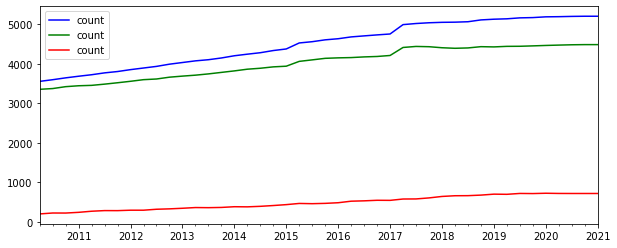

In [87]:
fig, ax = plt.subplots(figsize=(10,4))
periods.plot(ax=ax, color='blue')
periods_occ.plot(ax=ax, color='green')
periods_vac.plot(ax=ax, color='red')

### Join with postcodes to get coordinates

In [2]:
files = glob.glob('../data/retail/Whythawk/new_merged_reports/2021-03*')
df = pd.concat(map(pd.read_csv, files))

In [162]:
# filter boroughs that intersect study area
df = df[df['rates_authority_id'].isin(intersected_boroughs_list)]

In [163]:
df.shape

(181172, 25)

In [24]:
#remove spaces from postcode
df['pc__pcs'] = df['pc__pcs'].str.replace(" ", "")
postcodes['pcd2'] = postcodes['pcd2'].str.replace(" ", "")
postcodes_cropped = postcodes[postcodes.msoa11.isin(list(msoa_cropped['MSOA11CD']))]

In [165]:
df_cropped = df.merge(postcodes_cropped, how='inner', left_on='pc__pcs', right_on='pcd2')

In [166]:
print(df_cropped.shape)
df_cropped.isna().sum()

(146370, 29)


rates_code              56351
rates_authority_id          0
rates_authority             0
region                      0
location_code               0
address_no                  9
address_street            141
address_town                0
pc__pcs                     0
use_category                0
scat_code                   0
sub_category                0
category                10776
floor_area                  0
rental_valuation            0
valuation_date              0
revaluation_year            0
period                      0
rates_expected              0
name                    71967
rates_paid              81938
status                      0
status_date                 0
status_duration         69005
ratepayers_published        0
pcd2                        0
msoa11                      0
lat                         0
long                        0
dtype: int64

In [167]:
df_cropped[df_cropped.category.isna()][['sub_category','use_category']].value_counts()

sub_category          use_category                                              
Other Public          Communication Stations (National Scheme)                      2780
Other Commercial      Car Spaces                                                    1740
Other Public          Advertising Right                                             1578
                      Surgeries, Clinics, Health Centres (Rental Valuation)         1200
Other Commercial      Miscellaneous                                                  553
Other Public          Community Day Centres                                          536
                      Local Authority Schools (National Scheme)                      385
                      Garages (Transport and Commercial)                             230
Other Commercial      Clubs & Institutions                                           218
Other Public          Public and Independent Schools (National Scheme)               207
Other Commercial      Telecom

In [168]:
list(df_cropped['category'].unique())

['Office', 'Retail', 'Leisure', nan, 'Industrial']

In [241]:
categories = list(df_cropped['category'].unique())
msoa_to_categories = pd.DataFrame()
msoa_to_categories['total'] = df_cropped.groupby(['msoa11']).size()

for c in categories:
    msoa_to_categories[c] = df_cropped[df_cropped['category']==c].groupby(['msoa11']).size()

msoa_to_categories['ret_restaurants'] = df_cropped[df_cropped.sub_category=='Retail Restaurants & Cafes'].groupby(['msoa11']).size()
msoa_to_categories['ret_hs'] = df_cropped[df_cropped.sub_category=='Retail High Street'].groupby(['msoa11']).size()
msoa_to_categories['ret_superstores'] = df_cropped[df_cropped.sub_category=='Retail Other Superstores/ Retail Warehouses'].groupby(['msoa11']).size()

msoa_to_categories = msoa_to_categories.reset_index()

In [242]:
msoa_to_categories

,index,total,Office,Retail,Leisure,NaN,Industrial,ret_restaurants,ret_hs,ret_superstores
0,E02000001,22668,17640,3894,155.0,NaN,28.0,575,3243,6.0
1,E02000180,170,33,75,5.0,NaN,29.0,13,57,3.0
2,E02000183,469,247,157,4.0,NaN,26.0,39,117,1.0
3,E02000184,563,276,141,2.0,NaN,81.0,32,102,4.0
4,E02000186,1225,639,429,23.0,NaN,24.0,103,307,6.0
...,...,...,...,...,...,...,...,...,...,...
149,E02000983,129,36,58,1.0,NaN,2.0,7,50,NaN
150,E02006801,1035,460,372,16.0,NaN,55.0,107,253,4.0
151,E02006802,639,412,114,6.0,NaN,23.0,28,82,NaN
152,E02006853,559,362,83,6.0,NaN,8.0,6,76,NaN


In [243]:
msoa_to_categories = msoa_to_categories.fillna(0)
msoa_to_categories['other'] = msoa_to_categories['total'] - msoa_to_categories['Office'] - msoa_to_categories['Retail'] - msoa_to_categories['Leisure'] - msoa_to_categories['Industrial']

In [244]:
msoa_to_categories = msoa_to_categories[['index', 'total', 'Office', 'Retail', 'Leisure', 'Industrial', 'other',
                                        'ret_restaurants', 'ret_hs', 'ret_superstores']]
msoa_to_categories.columns = ['msoa11', 'total', 'office', 'retail', 'leisure', 'industrial', 'other',
                             'ret_restaurants', 'ret_hs', 'ret_superstores']

In [245]:
for col in msoa_to_categories.columns[1:]:
    msoa_to_categories[col] = msoa_to_categories[col].astype(int)

In [4]:
msoa_to_categories.to_csv('../data/x/msoa_to_categories202103.csv', index=False)

Repeat for other periods

In [ ]:
# files = glob.glob('../data/retail/Whythawk/new_merged_reports/2020-03*')
# df202003 = pd.concat(map(pd.read_csv, files))

# files = glob.glob('../data/retail/Whythawk/new_merged_reports/2019-03*')
# df201903 = pd.concat(map(pd.read_csv, files))

# files = glob.glob('../data/retail/Whythawk/new_merged_reports/2020-06*')
# df202006 = pd.concat(map(pd.read_csv, files))

files = glob.glob('../data/retail/Whythawk/new_merged_reports/2019-06*')
df201906 = pd.concat(map(pd.read_csv, files))

In [ ]:
def aggregate_to_msoa(df):
    df = df[df['rates_authority_id'].isin(intersected_boroughs_list)]
    df['pc__pcs'] = df['pc__pcs'].str.replace(" ", "")
    df_cropped = df.merge(postcodes_cropped, how='inner', left_on='pc__pcs', right_on='pcd2')
    categories = list(df_cropped['category'].unique())
    
    msoa_to_categories = pd.DataFrame()
    msoa_to_categories['total'] = df_cropped.groupby(['msoa11']).size()

    for c in categories:
        msoa_to_categories[c] = df_cropped[df_cropped['category']==c].groupby(['msoa11']).size()
    msoa_to_categories['ret_restaurants'] = df_cropped[df_cropped.sub_category=='Retail Restaurants & Cafes'].groupby(['msoa11']).size()
    msoa_to_categories['ret_hs'] = df_cropped[df_cropped.sub_category=='Retail High Street'].groupby(['msoa11']).size()
    msoa_to_categories['ret_superstores'] = df_cropped[df_cropped.sub_category=='Retail Other Superstores/ Retail Warehouses'].groupby(['msoa11']).size()
    msoa_to_categories = msoa_to_categories.reset_index()
    msoa_to_categories = msoa_to_categories.fillna(0)
    msoa_to_categories['other'] = msoa_to_categories['total'] - msoa_to_categories['Office'] - msoa_to_categories['Retail'] - msoa_to_categories['Leisure'] - msoa_to_categories['Industrial']
    msoa_to_categories = msoa_to_categories[['index', 'total', 'Office', 'Retail', 'Leisure', 'Industrial', 'other',
                                        'ret_restaurants', 'ret_hs', 'ret_superstores']]
    msoa_to_categories.columns = ['msoa11', 'total', 'office', 'retail', 'leisure', 'industrial', 'other',
                             'ret_restaurants', 'ret_hs', 'ret_superstores']
    for col in msoa_to_categories.columns[1:]:
        msoa_to_categories[col] = msoa_to_categories[col].astype(int)
    return msoa_to_categories

In [ ]:
msoa_to_categories202003 = aggregate_to_msoa(df202003)
msoa_to_categories201903 = aggregate_to_msoa(df201903)
msoa_to_categories202006 = aggregate_to_msoa(df202006)
msoa_to_categories201906 = aggregate_to_msoa(df201906)

In [ ]:
msoa_to_categories202003.to_csv('../data/x/msoa_to_categories202003.csv', index=False)
msoa_to_categories201903.to_csv('../data/x/msoa_to_categories201903.csv', index=False)
msoa_to_categories202006.to_csv('../data/x/msoa_to_categories202006.csv', index=False)
msoa_to_categories201906.to_csv('../data/x/msoa_to_categories201906.csv', index=False)